## Generation of the prototype

- [#] 5000 skills combinations, 5 generations per skill combination
- [ ] tech + managment
- [X] use new $\mathcal{F}$
- [X] use combination size dist $\mathcal{N} \sim U(1, 10)$

In [1]:
import pickle
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import json
from generator import SkillsGenerator, DatasetGenerator
from tqdm.notebook import tqdm
from transformers import AutoModel, AutoTokenizer
import gen_prompt_template
from importlib import reload
import pickle
from api_key import API_KEY
import seaborn as sns
tqdm.pandas()


%load_ext autoreload
%autoreload 2

In [2]:
## Loading the embedded taxonomy
ESCO_DIR = "../../../../esco/"
with open(ESCO_DIR + "embedded_tech_management_tax.pkl", "rb") as f:
    tech_emb_tax = pickle.load(f)
    tech_emb_tax["embeddings"] = tech_emb_tax["embeddings"].apply(lambda x : x.detach())

## ESCO technical skills
tech_skills = pd.read_csv(ESCO_DIR + "tech_managment_taxonomy_narrow.csv")
tech_skills["name+definition"] = tech_skills["name+defintion"]

## popularity measures
F = pd.read_csv("../ppl_3_sentences_all_skills.csv").drop("Unnamed: 0", axis=1)[["name", "mean_std_ppl"]].set_index("name").to_dict()["mean_std_ppl"]

## Loading the combination dist
MAX_NB_SKILL = 10
combination_dist = np.ones(MAX_NB_SKILL) / MAX_NB_SKILL

## Models (useless for now)
word_emb = "jjzha/jobbert-base-cased"
word_emb_model = AutoModel.from_pretrained(word_emb)
word_emb_tokenizer = AutoTokenizer.from_pretrained(word_emb)
additional_info = tech_skills[["name", "Definition", "Type Level 1", "Type Level 2", "altLabels", "Type Level 3"]].drop_duplicates("name").set_index("name").to_dict("index")


gen = SkillsGenerator(taxonomy=tech_emb_tax, 
                taxonomy_is_embedded=True,
                combination_dist=combination_dist,
                popularity=F)

datagen = DatasetGenerator(tech_emb_tax,
                           None, ## no references, we work in Zero-Shot
                           word_emb_model,
                           word_emb_tokenizer,
                           additional_info)


Some weights of BertModel were not initialized from the model checkpoint at jjzha/jobbert-base-cased and are newly initialized: ['bert.pooler.dense.bias', 'bert.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [3]:
def save_generation(text_file, res):
    tres = ""
    for (skills, job_posting) in res:
        tres += "skills : "+str(skills) + "\n"
        tres += (job_posting if job_posting is not None else "[NULL]") + "\n"
        tres += "-"*100 + "\n"

    with open(text_file, "w") as f:
        f.write(tres)

    print("Result saved in : ./" + text_file)


def save_json(text_file, res):
    tres = []
    for (skills, job_posting) in res:
        tres.append({'skills': skills, 'description': job_posting})

    with open(text_file, "w") as f:
        json.dump(tres, f)

    print("Result saved in : ./" + text_file)

In [6]:
gen_args = {
"nb_generation" : 4000, # number of samples
"threshold" : 0.75, # not considering skills that are less than .8 similar
"beam_size" : 30, # considering 20 skills
"temperature_pairing": 1, # popularity to be skewed toward popular skills
"temperature_sample_size": 1,
"frequency_select": True, # wether we select within the NN acording to frequency
"upper_bound_skill_matching": 10
}


combinations = list(gen.balanced_nbred_iter(**gen_args))


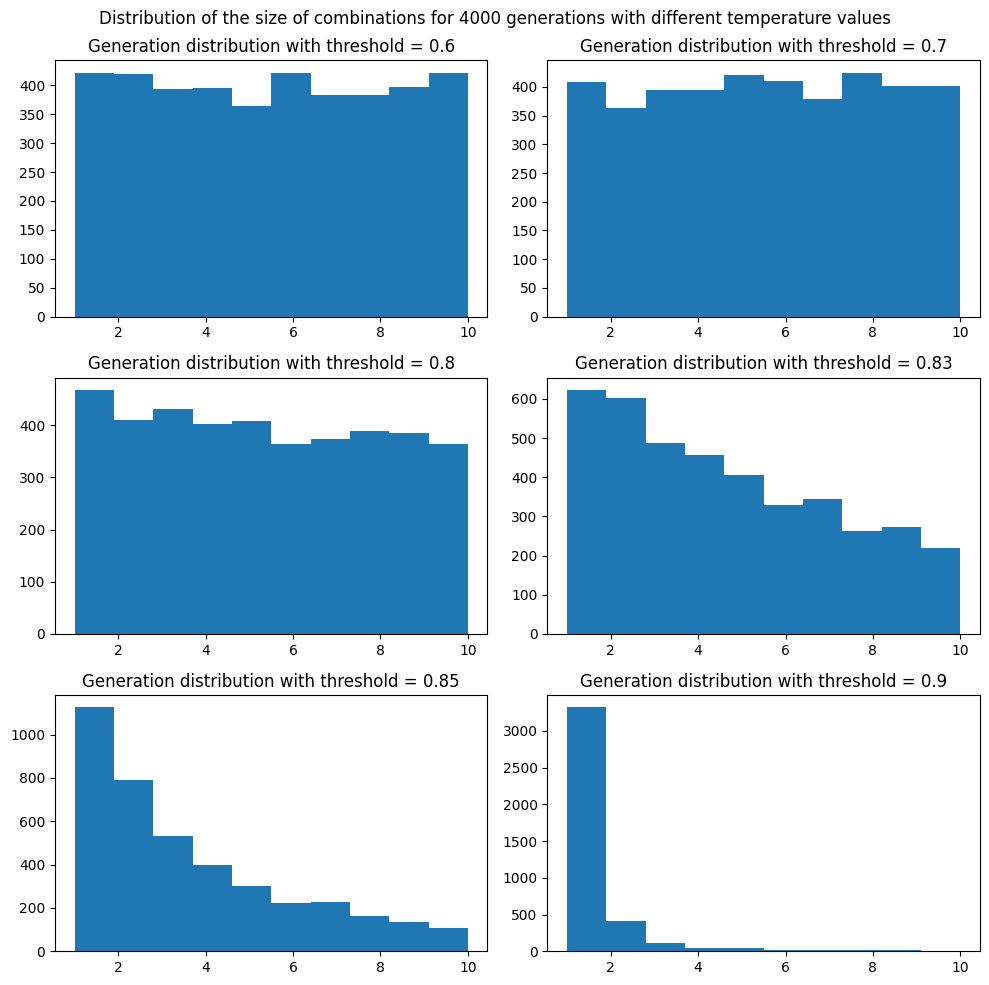

In [15]:
f, a = plt.subplots(3, 2, figsize=(10, 10))
for T, ax in zip([.6, .7, .8, .83, .85, .9], a.flatten()):
    gen_args = {
    "nb_generation" : 4000, # number of samples
    "threshold" : T, # not considering skills that are less than .8 similar
    "beam_size" : 30, # considering 20 skills
    "temperature_pairing": 1, # popularity to be skewed toward popular skills
    "temperature_sample_size": 1,
    "frequency_select": True, # wether we select within the NN acording to frequency
    "upper_bound_skill_matching": 10
    }


    combinations = list(gen.balanced_nbred_iter(**gen_args))

    lens = [len(comb) for comb in combinations]
    ax.hist(lens)
    ax.set_title(f"Generation distribution with threshold = {T}")

f.suptitle("Distribution of the size of combinations for 4000 generations with different temperature values")
plt.tight_layout()


In [5]:
gen_args = {
"nb_generation" : 5, # number of samples
"threshold" : 0.84, # not considering skills that are less than .8 similar
"beam_size" : 30, # considering 20 skills
"temperature_pairing": 1, # popularity to be skewed toward popular skills
"temperature_sample_size": 1,
"frequency_select": True, # wether we select within the NN acording to frequency
"upper_bound_skill_matching": 2
}


combinations = list(gen.balanced_nbred_iter(**gen_args))

In [16]:
datagen.create_prompt_for("GEN-B1", ["SQL", "Hadoop", "THC Hydra"], specific_few_shots=False, number_few_shots=0, shot_sim_threshold=0, prompt_args={})

prompts arguments >  []
prompt args : {}
prompts arguments >  ['nExamples', 'minNbSentences', 'maxNbSentences', 'minNbSentences', 'maxNbSentences', 'wordsToAvoid', 'typeOfAdditionalInfo', 'additionalInfo']
prompt args : {'nExamples': 'five', 'minNbSentences': '1 sentence', 'maxNbSentences': '4', 'wordsToAvoid': 'You must not use any of these ESCO skills in the job description : data extraction, transformation and loading tools, XQuery, John The Ripper (penetration testing tool), Backbox (penetration testing tool), SPARQL, MarkLogic. ', 'typeOfAdditionalInfo': 'Alternative names (you may discard this information if irrelevant)', 'additionalInfo': "1) SQL : can also be referred as : Informix 4GL/SQL | SEQUEL | SQL | Subquery and described as : The computer language SQL is a query language for retrieval of information from a database and of documents containing the needed information. It is developed by the American National Standards Institute and the International Organization for Stand

[{'role': 'system',
  'content': "You are the leading AI Writer at a large, multinational HR agency. You are considered as the world's best expert at expressing required skills and knowledge in a variety of clear ways. You are particularly proficient with the ESCO Occupation and Skills framework. As you are widely lauded for your job posting writing ability, you will assist the user in all job-posting, job requirements and occupational skills related tasks.\n"},
 {'role': 'user',
  'content': "You work in collaboration with ESCO to gather rigid standards for job postings. Given a list of ESCO skills and knowledges, you're asked to provide five paragraphs that could be found in a job ad and refer to all skill or knowledge component. The paragraphs must have varying length between 1 sentence and 4 sentences. The first description must be exactly and precisely 1 sentence long. The last description must be exactly and precisely 4 sentences long. All the description should mention at least 

In [5]:
generation_args = {
    "skill_generator": [["Hadoop"]], # sample generator
    "specific_few_shots": False, # enable the use of specific few shots
    "model": "gpt-3.5",
    "gen_mode": "GEN-B1"
    }
res = datagen.generate_ds(**generation_args)
save_generation("generated/TEST_SHORT_GEN_B1_HADOOP_2.txt", res)


generation_args = {
    "skill_generator": [["SQL", "Hadoop"]], # sample generator
    "specific_few_shots": False, # enable the use of specific few shots
    "model": "gpt-3.5",
    "gen_mode": "GEN-B1"
    }
res = datagen.generate_ds(**generation_args)
save_generation("generated/TEST_SHORT_GEN_B1_SQL_HADOOP_2.txt", res)


generation_args = {
    "skill_generator": [["SQL", "Hadoop", "machine learning"]], # sample generator
    "specific_few_shots": False, # enable the use of specific few shots
    "model": "gpt-3.5",
    "gen_mode": "GEN-B1"
    }
res = datagen.generate_ds(**generation_args)
save_generation("generated/TEST_SHORT_GEN_B1_ML_2.txt", res)

  0%|          | 0/1 [00:00<?, ?it/s]

prompts arguments >  []
prompt args : {}
prompts arguments >  ['nExamples', 'minNbSentences', 'maxNbSentences', 'minNbSentences', 'maxNbSentences', 'typeOfAdditionalInfo', 'additionalInfo']
prompt args : {'nExamples': 'five', 'minNbSentences': '1 sentence', 'maxNbSentences': '2', 'typeOfAdditionalInfo': 'Alternative names (you may discard this information if irrelevant)', 'additionalInfo': '1) Hadoop : can also be referred as : Hadoop and described as : The open-source data storing, analysis and processing framework which consists mainly in the MapReduce and Hadoop distributed file system (HDFS) components and it is used to provide support for managing and analysing large datasets..'}
----------------------------------------------------------------------------------------------------
You are the leading AI Writer at a large, multinational HR agency. You are considered as the world's best expert at expressing required skills and knowledge in a variety of clear ways. You are particularly

  0%|          | 0/1 [00:00<?, ?it/s]

prompts arguments >  []
prompt args : {}
prompts arguments >  ['nExamples', 'minNbSentences', 'maxNbSentences', 'minNbSentences', 'maxNbSentences', 'typeOfAdditionalInfo', 'additionalInfo']
prompt args : {'nExamples': 'five', 'minNbSentences': '1 sentence', 'maxNbSentences': '3', 'typeOfAdditionalInfo': 'Alternative names (you may discard this information if irrelevant)', 'additionalInfo': '1) SQL : can also be referred as : Informix 4GL/SQL | SEQUEL | SQL | Subquery and described as : The computer language SQL is a query language for retrieval of information from a database and of documents containing the needed information. It is developed by the American National Standards Institute and the International Organization for Standardization..2) Hadoop : can also be referred as : Hadoop and described as : The open-source data storing, analysis and processing framework which consists mainly in the MapReduce and Hadoop distributed file system (HDFS) components and it is used to provide sup

  0%|          | 0/1 [00:00<?, ?it/s]

prompts arguments >  []
prompt args : {}
prompts arguments >  ['nExamples', 'minNbSentences', 'maxNbSentences', 'minNbSentences', 'maxNbSentences', 'typeOfAdditionalInfo', 'additionalInfo']
prompt args : {'nExamples': 'five', 'minNbSentences': '1 sentence', 'maxNbSentences': '4', 'typeOfAdditionalInfo': 'Alternative names (you may discard this information if irrelevant)', 'additionalInfo': '1) SQL : can also be referred as : Informix 4GL/SQL | SEQUEL | SQL | Subquery and described as : The computer language SQL is a query language for retrieval of information from a database and of documents containing the needed information. It is developed by the American National Standards Institute and the International Organization for Standardization..2) Hadoop : can also be referred as : Hadoop and described as : The open-source data storing, analysis and processing framework which consists mainly in the MapReduce and Hadoop distributed file system (HDFS) components and it is used to provide sup

In [6]:
gen_args = {
"nb_generation" : 10, # number of samples
"threshold" : 0.84, # not considering skills that are less than .8 similar
"beam_size" : 30, # considering 20 skills
"temperature_pairing": 1, # popularity to be skewed toward popular skills
"temperature_sample_size": 1,
"frequency_select": True, # wether we select within the NN acording to frequency
"upper_bound_skill_matching": 2
}


combinations = list(gen.balanced_nbred_iter(**gen_args))

generation_args = {
    "skill_generator": combinations, # sample generator
    "specific_few_shots": False, # enable the use of specific few shots
    "model": "gpt-3.5",
    "gen_mode": "GEN-B1"
    }

res = datagen.generate_ds(**generation_args)
save_generation("generated/PROTO_GEN_B1_10GENS.txt", res)

  0%|          | 0/10 [00:00<?, ?it/s]

prompts arguments >  []
prompt args : {}
prompts arguments >  ['nExamples', 'minNbSentences', 'maxNbSentences', 'minNbSentences', 'maxNbSentences', 'typeOfAdditionalInfo', 'additionalInfo']
prompt args : {'nExamples': 'five', 'minNbSentences': '1 sentence', 'maxNbSentences': '2', 'typeOfAdditionalInfo': 'Alternative names (you may discard this information if irrelevant)', 'additionalInfo': '1) operate train integrated electronic control centre : can also be referred as : operate rail integrated electronic control centre | operate integrated electronic control centres for trains | undertake integrated electronic control centre operations | perform integrated electronic control centre operations | operate train integrated electronic control center | execute integrated electronic control centre operations | carry out integrated electronic control centre operations | operate train electronic integrated control centre | operate railway integrated electronic control centre | operate integrat

In [7]:
datagen.create_prompt_for("GEN-A0", ["SQL", "Hadoop", "machine learning"], specific_few_shots=False, number_few_shots=0, shot_sim_threshold=0, prompt_args={"nExamples":2})

prompts arguments >  []
prompt args : {}
prompts arguments >  ['nExamples', 'typeOfAdditionalInfo', 'additionalInfo']
prompt args : {'nExamples': 2, 'typeOfAdditionalInfo': 'Alternative names (you may discard this information if irrelevant)', 'additionalInfo': '1) SQL : can also be referred as : Informix 4GL/SQL | SEQUEL | SQL | Subquery and described as : The computer language SQL is a query language for retrieval of information from a database and of documents containing the needed information. It is developed by the American National Standards Institute and the International Organization for Standardization..2) Hadoop : can also be referred as : Hadoop and described as : The open-source data storing, analysis and processing framework which consists mainly in the MapReduce and Hadoop distributed file system (HDFS) components and it is used to provide support for managing and analysing large datasets..3) machine learning : can also be referred as : ML and described as : The principles

[{'role': 'system',
  'content': "You are the leading AI Writer at a large, multinational HR agency. You are considered as the world's best expert at expressing required skills and knowledge in a variety of clear ways. You are particularly proficient with the ESCO Occupation and Skills framework. As you are widely lauded for your job posting writing ability, you will assist the user in all job-posting, job requirements and occupational skills related tasks.\n"},
 {'role': 'user',
  'content': "You work in collaboration with ESCO to gather rigid standards for job postings. Given a list of ESCO skills and knowledges, you're asked to provide 2 of one sentence that could be found in a job ad and refer to all skill or knowledge component. You may be given a skill family to help you disambiguate if the skills names could refer to multiple things. Ensure that your sentences are well written and could be found in real job advertisement. Write a variety of different examples and ensure your sen

In [5]:
for mod in ["GEN-A0", "GEN-A1", "GEN-B1"]:

    generation_args = {
        "skill_generator": [["SQL", "Hadoop", "machine learning"]], 
        "specific_few_shots": False,
        "model": "gpt-3.5",
        "gen_mode": mod,
        "prompt_args" : {
            "nExamples":2
        }
        }
    res = datagen.generate_ds(**generation_args)
    save_generation(f"generated/comparaison/TEST_{mod}.txt", res)

  0%|          | 0/1 [00:00<?, ?it/s]

prompts arguments >  []
prompt args : {}
prompts arguments >  ['nExamples', 'typeOfAdditionalInfo', 'additionalInfo']
prompt args : {'nExamples': 2, 'typeOfAdditionalInfo': 'Alternative names (you may discard this information if irrelevant)', 'additionalInfo': '1) SQL : can also be referred as : Informix 4GL/SQL | SEQUEL | SQL | Subquery and described as : The computer language SQL is a query language for retrieval of information from a database and of documents containing the needed information. It is developed by the American National Standards Institute and the International Organization for Standardization..2) Hadoop : can also be referred as : Hadoop and described as : The open-source data storing, analysis and processing framework which consists mainly in the MapReduce and Hadoop distributed file system (HDFS) components and it is used to provide support for managing and analysing large datasets..3) machine learning : can also be referred as : ML and described as : The principles

  0%|          | 0/1 [00:00<?, ?it/s]

prompts arguments >  []
prompt args : {}
prompts arguments >  ['nExamples', 'implicitCount', 'typeOfAdditionalInfo', 'additionalInfo']
prompt args : {'nExamples': 2, 'implicitCount': 'two', 'typeOfAdditionalInfo': 'Alternative names (you may discard this information if irrelevant)', 'additionalInfo': '1) SQL : can also be referred as : Informix 4GL/SQL | SEQUEL | SQL | Subquery and described as : The computer language SQL is a query language for retrieval of information from a database and of documents containing the needed information. It is developed by the American National Standards Institute and the International Organization for Standardization..2) Hadoop : can also be referred as : Hadoop and described as : The open-source data storing, analysis and processing framework which consists mainly in the MapReduce and Hadoop distributed file system (HDFS) components and it is used to provide support for managing and analysing large datasets..3) machine learning : can also be referred 

  0%|          | 0/1 [00:00<?, ?it/s]

prompts arguments >  []
prompt args : {}
prompts arguments >  ['nExamples', 'minNbSentences', 'maxNbSentences', 'minNbSentences', 'maxNbSentences', 'typeOfAdditionalInfo', 'additionalInfo']
prompt args : {'nExamples': 2, 'minNbSentences': '1 sentence', 'maxNbSentences': '4', 'typeOfAdditionalInfo': 'Alternative names (you may discard this information if irrelevant)', 'additionalInfo': '1) SQL : can also be referred as : Informix 4GL/SQL | SEQUEL | SQL | Subquery and described as : The computer language SQL is a query language for retrieval of information from a database and of documents containing the needed information. It is developed by the American National Standards Institute and the International Organization for Standardization..2) Hadoop : can also be referred as : Hadoop and described as : The open-source data storing, analysis and processing framework which consists mainly in the MapReduce and Hadoop distributed file system (HDFS) components and it is used to provide support 

### Try with span highlights

In [9]:
mod = "GEN-C0"
generation_args = {
        "skill_generator": [["SQL", "Hadoop", "search engines"]], 
        "specific_few_shots": False,
        "model": "gpt-3.5",
        "gen_mode": mod,
        "prompt_args" : {
            "nExamples":2
        }
        }
res = datagen.generate_ds(**generation_args)
save_generation(f"generated/comparaison/TEST_{mod}_2.txt", res)

  0%|          | 0/1 [00:00<?, ?it/s]

prompts arguments >  []
prompt args : {}
prompts arguments >  ['nExamples', 'wordsToAvoid', 'typeOfAdditionalInfo', 'additionalInfo']
['SQL', 'Hadoop', 'search engines']
prompt args : {'nExamples': 2, 'wordsToAvoid': 'You must not use any of these ESCO skills in the job description : debt collection techniques, data extraction, transformation and loading tools, MarkLogic, SPARQL, conduct web searches, XQuery. ', 'typeOfAdditionalInfo': 'Alternative names (you may discard this information if irrelevant)', 'additionalInfo': '1) SQL : can also be referred as : Informix 4GL/SQL | SEQUEL | SQL | Subquery and described as : The computer language SQL is a query language for retrieval of information from a database and of documents containing the needed information. It is developed by the American National Standards Institute and the International Organization for Standardization..2) Hadoop : can also be referred as : Hadoop and described as : The open-source data storing, analysis and process

# Prototype (with 10 samples)

In [6]:
for mod in ["PROTO-GEN-A0", "PROTO-GEN-A1"]:

    generation_args = {
        "skill_generator": [["SQL", "Hadoop", "machine learning"]], 
        "specific_few_shots": False,
        "model": "gpt-3.5",
        "gen_mode": mod
        }
    res = datagen.generate_ds(**generation_args)
    save_generation(f"generated/comparaison/TEST_{mod}.txt", res)

  0%|          | 0/1 [00:00<?, ?it/s]

prompts arguments >  []
prompt args : {}
prompts arguments >  ['skillList', 'wordsToAvoid']
['SQL', 'Hadoop', 'machine learning']
prompt args : {'skillList': "['SQL', 'Hadoop', 'machine learning']", 'wordsToAvoid': 'You must not use any of these ESCO skills in the job description : deep learning, MarkLogic, data extraction, transformation and loading tools, ML (computer programming), XQuery, SPARQL. '}
----------------------------------------------------------------------------------------------------
You are the leading AI Writer at a large, multinational HR agency. You are considered as the world's best expert at expressing required skills and knowledge in a variety of clear ways. You are particularly proficient with the ESCO Occupation and Skills framework. As you are widely lauded for your job posting writing ability, you will assist the user in all job-posting, job requirements and occupational skills related tasks.

You work in collaboration with ESCO to gather rigid standards fo

  0%|          | 0/1 [00:00<?, ?it/s]

prompts arguments >  []
prompt args : {}
prompts arguments >  ['wordsToAvoid']
['SQL', 'Hadoop', 'machine learning']
prompt args : {'wordsToAvoid': 'You must not use any of these ESCO skills in the job description : deep learning, MarkLogic, data extraction, transformation and loading tools, ML (computer programming), XQuery, SPARQL. '}
----------------------------------------------------------------------------------------------------
You are the leading AI Writer at a large, multinational HR agency. You are considered as the world's best expert at expressing required skills and knowledge in a variety of clear ways. You are particularly proficient with the ESCO Occupation and Skills framework. As you are widely lauded for your job posting writing ability, you will assist the user in all job-posting, job requirements and occupational skills related tasks.

You work in collaboration with ESCO to gather rigid standards for job postings. Given a list of ESCO skills and knowledges, you're 

In [27]:
from time import time

start_combin_gen = time()
gen_args = {
"nb_generation" : 10, # number of samples
"threshold" : 0.84, # not considering skills that are less than .8 similar
"beam_size" : 30, # considering 20 skills
"temperature_pairing": 1, # popularity to be skewed toward popular skills
"temperature_sample_size": 1,
"frequency_select": True, # wether we select within the NN acording to frequency
"upper_bound_skill_matching": 2
}


combinations = list(gen.balanced_nbred_iter(**gen_args))

print(f"> {round(time() - start_combin_gen, 2)}s to generate the samples.")


for mod in ["GEN-A1"]:
    start_gen = time()
    generation_args = {
        "skill_generator": combinations, 
        "specific_few_shots": False,
        "model": "gpt-3.5",
        "gen_mode": mod,
        "prompt_args" : {
            "nExamples":2
        }
    }
    res = datagen.generate_ds(**generation_args)
    save_generation(f"generated/PROTOTYPE/gens{mod}.txt", res)
    print(f"> {round(time() - start_gen, 2)}s to generate the job description with {mod}.")

  0%|          | 0/10 [00:00<?, ?it/s]

prompts arguments >  []
prompt args : {}
prompts arguments >  ['nExamples', 'implicitCount', 'wordsToAvoid', 'typeOfAdditionalInfo', 'additionalInfo']
['computer science', 'cybernetics', 'machine learning']
prompt args : {'nExamples': 2, 'implicitCount': 'two', 'wordsToAvoid': 'You must not use any of these ESCO skills in the job description : systems theory, object-oriented modelling, ML (computer programming), engineering control theory, deep learning, metalogic. ', 'typeOfAdditionalInfo': 'Alternative names (you may discard this information if irrelevant)', 'additionalInfo': '1) computer science : can also be referred as : computer science | informatics studies | informatics and described as : The scientific and practical study that deals with the foundations of information and computation, namely algorithms, data structures, programming, and data architecture. It deals with the practicability, structure and mechanisation of the methodical procedures that manage the acquisition, pro

In [15]:
from time import time
from collections import Counter
import seaborn as sns


start_combin_gen = time()
gen_args = {
"nb_generation" : 5_000, # number of samples
"threshold" : 0.84, # not considering skills that are less than .8 similar
"beam_size" : 20, # considering 20 skills
"temperature_pairing": 1, # popularity to be skewed toward popular skills
"temperature_sample_size": 1,
"frequency_select": True, # wether we select within the NN acording to frequency
"upper_bound_skill_matching": 10
}


combinations = list(gen.balanced_nbred_iter(**gen_args))
print(f"> {round(time() - start_combin_gen, 2)}s to generate the samples.")


> 2.64s to generate the samples.


/mnt/u14157_ic_nlp_001_files_nfs/nlpdata1/home/magron/miniconda3/envs/nlp1/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/mnt/u14157_ic_nlp_001_files_nfs/nlpdata1/home/magron/miniconda3/envs/nlp1/lib/python3.9/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


Text(0, 0.5, 'Number of skills')

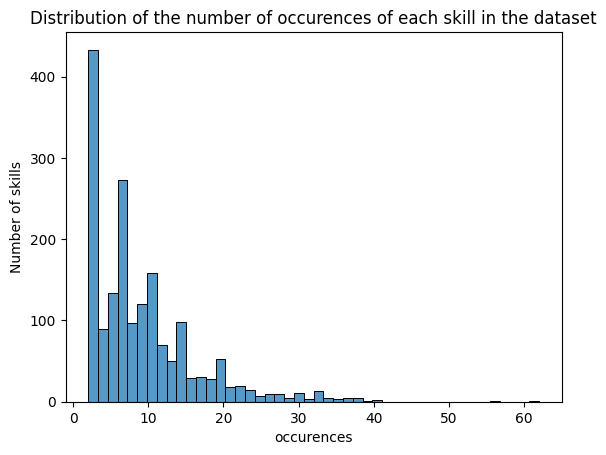

In [16]:
occs = pd.DataFrame.from_dict(Counter(sum(combinations, [])), "index").reset_index()
occs.columns = ["skills", "occurences"]
g = sns.histplot(data=occs, x="occurences")
g.set_title("Distribution of the number of occurences of each skill in the dataset")
g.set_ylabel("Number of skills")

In [17]:
display(occs.sort_values("occurences").head(10))
display(occs.sort_values("occurences").tail(10))

,skills,occurences
412,ATM systems,2
1592,communicate gambling rules,2
1606,confront offenders,2
307,oversee clinical information system activities,2
1112,assemble video tape footage,2
1623,develop terminology databases,2
1625,interpret prescriptions,2
226,identify music with commercial potential,2
1076,read people,2
1631,study court hearings,2


,skills,occurences
436,perform a feasibility study on biomass systems,37
502,Objective-C,38
263,SQL Server Integration Services,38
97,analyse scientific data,38
42,perform feasibility study on geothermal energy,38
538,Scratch (computer programming),39
56,Erlang,40
860,Smalltalk (computer programming),40
238,collect financial data,56
28,perform data analysis,62


Text(0, 0.5, 'Number of generation')

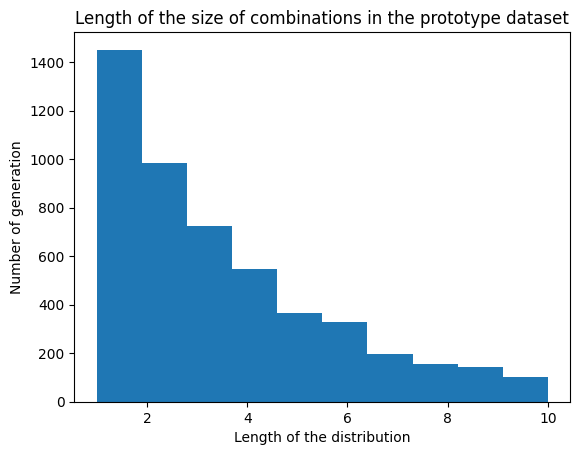

In [18]:
f, g = plt.subplots()
plt.hist([len(x) for x in combinations])
g.set_title("Length of the size of combinations in the prototype dataset")
g.set_xlabel("Length of the distribution")
g.set_ylabel("Number of generation")

In [29]:
generation_args = {
        "skill_generator": combinations, 
        "specific_few_shots": False,
        "model": "gpt-3.5",
        "gen_mode": "PROTOTYPE",
        "autosave": True,
        "autosave_file": "generated/PROTOTYPE/prototype.json",
        "checkpoints_freq":10
    }
res = datagen.generate_ds(**generation_args)
save_generation(f"generated/PROTOTYPE/PROTOTYPE.txt", res)

0it [00:00, ?it/s]

> saved checkpoint at 10
> saved checkpoint at 20
> saved checkpoint at 30
> saved checkpoint at 40
> saved checkpoint at 50
> saved checkpoint at 60
> saved checkpoint at 70
> saved checkpoint at 80
> saved checkpoint at 90
> saved checkpoint at 100
> saved checkpoint at 110
> saved checkpoint at 120
> saved checkpoint at 130
> saved checkpoint at 140
> saved checkpoint at 150
> saved checkpoint at 160
> saved checkpoint at 170
> saved checkpoint at 180
> saved checkpoint at 190
> saved checkpoint at 200
> saved checkpoint at 210
> saved checkpoint at 220
> saved checkpoint at 230
> saved checkpoint at 240
> saved checkpoint at 250
> saved checkpoint at 260
> saved checkpoint at 270
> saved checkpoint at 280
Timed out Request timed out: HTTPSConnectionPool(host='api.openai.com', port=443): Read timed out. (read timeout=20). Waiting for 10 seconds.
> saved checkpoint at 290
> saved checkpoint at 300
> saved checkpoint at 310
> saved checkpoint at 320
> saved checkpoint at 330
> saved c

KeyboardInterrupt: 

In [6]:
gen_args = {
"nb_generation" : 2270, # number of samples
"threshold" : 0.84, # not considering skills that are less than .8 similar
"beam_size" : 20, # considering 20 skills
"temperature_pairing": 1, # popularity to be skewed toward popular skills
"temperature_sample_size": 1,
"frequency_select": True, # wether we select within the NN acording to frequency
"upper_bound_skill_matching": 10
}


combinations = list(gen.balanced_nbred_iter(**gen_args))

In [ ]:
generation_args = {
        "skill_generator": combinations, 
        "specific_few_shots": False,
        "model": "gpt-3.5",
        "gen_mode": "PROTOTYPE",
        "autosave": True,
        "autosave_file": "generated/PROTOTYPE/prototype_2.json",
        "checkpoints_freq":10
    }
res = datagen.generate_ds(**generation_args)
save_generation(f"generated/PROTOTYPE/PROTOTYPE.txt", res)

In [14]:
with open("generated/PROTOTYPE/prototype.json") as p1:
    p1_samples = json.load(p1)

with open("generated/PROTOTYPE/prototype_2.json") as p2:
    p2_samples = json.load(p2)

In [15]:
print(len(p1_samples))
print(len(p2_samples))
print(len(p1_samples + p2_samples))

4744
3940
8684


In [18]:
all_samples = p1_samples + p2_samples

BertTokenizerFast(name_or_path='jjzha/jobbert-base-cased', vocab_size=28996, model_max_length=1000000000000000019884624838656, is_fast=True, padding_side='right', truncation_side='right', special_tokens={'unk_token': '[UNK]', 'sep_token': '[SEP]', 'pad_token': '[PAD]', 'cls_token': '[CLS]', 'mask_token': '[MASK]'}, clean_up_tokenization_spaces=True)

/mnt/u14157_ic_nlp_001_files_nfs/nlpdata1/home/magron/miniconda3/envs/nlp1/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/mnt/u14157_ic_nlp_001_files_nfs/nlpdata1/home/magron/miniconda3/envs/nlp1/lib/python3.9/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/mnt/u14157_ic_nlp_001_files_nfs/nlpdata1/home/magron/miniconda3/envs/nlp1/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/mnt/u14157_ic_nlp_001_files_nfs/nlpdata1/

Text(0, 0.5, 'Number of combinations')

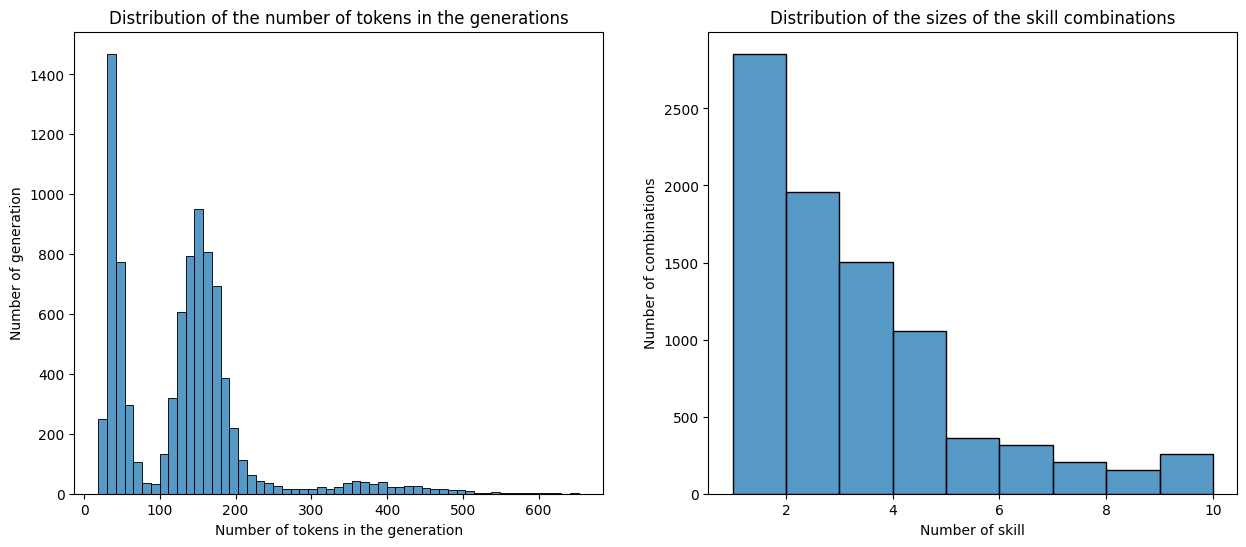

In [40]:
skills, descriptions = zip(*all_samples)
gen_ds = pd.DataFrame({'skills' : skills, 'sentence': descriptions}).dropna()
gen_ds["sentence_len"] = gen_ds["sentence"].progress_apply(lambda x : len(word_emb_tokenizer(x, truncation=True)["input_ids"]))
gen_ds["skill_number"] = gen_ds["skills"].apply(lambda x : len(x))

f, a = plt.subplots(1, 2, figsize=(15, 6))
g = sns.histplot(data=gen_ds, x="sentence_len", ax=a[0])
g.set_title("Distribution of the number of tokens in the generations")
g.set_xlabel("Number of tokens in the generation")
g.set_ylabel("Number of generation")

g = sns.histplot(data=gen_ds, x="skill_number", ax=a[1], binwidth=1)
g.set_title("Distribution of the sizes of the skill combinations")
g.set_xlabel("Number of skill")
g.set_ylabel("Number of combinations")


In [43]:
gen_ds.to_csv("./generated/PROTOTYPE/prototype.csv")

## Negative samples

In [13]:
res = datagen.augment_with_no_label_negative_sample(n=60, model="gpt-3.5")

TYPE-1
3
TYPE-2
1


In [11]:
[print(r) for r in res]

1. "Join our global organization headquartered in the vibrant city of New York, with over 10,000 employees, and be part of an industry leader in technology innovation."
2. "Be part of our dynamic team in London, where our diverse workforce of 5,000 employees is driving exceptional growth in the financial services industry."
3. "Join our fast-growing startup in San Francisco, where we are revolutionizing the healthcare sector with a dedicated team of 100 employees."
4. "Join our established manufacturing company in Tokyo, where our 20,000 employees are at the forefront of delivering high-quality products to customers worldwide."
5. "Be part of our innovative retail company in Berlin, where our team of 2,500 employees is disrupting the e-commerce industry and experiencing exponential growth."
6. "Join our renowned consulting firm in Paris, where our global team of 15,000 employees is shaping the future of business strategy for leading organizations."
7. "Embark on a career with our cutti

[None]

In [17]:
[print(ri) for ri in res]

1. "Join a thriving global company with a strong presence in the tech industry, boasting over 10,000 employees worldwide."
2. "Be a part of a leading pharmaceutical organization, headquartered in Europe and with operations spanning across multiple continents."
3. "Get on board with a dynamic start-up based in Silicon Valley, positioned to revolutionize the fintech sector and backed by top venture capitalists."
4. "Become a team member of a renowned fashion brand that has established its footprint across Asia, Europe, and North America."
5. "Take your career to new heights with a premier aerospace manufacturer, operating in several countries and recognized for cutting-edge innovations."
6. "Join an established telecommunications giant offering advanced solutions to clients globally with a workforce of over 50,000 professionals."
7. "Join a rapidly expanding e-commerce platform headquartered in the heart of Southeast Asia, serving millions of customers across the region."
8. "Embark on a

[None, None, None, None]